# Finetuning for classification

## Preparing the datase

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow", # for open ai pretrained wights
    "pandas",
    "polars"
]

for p in pkgs:
    print(f"{p}: {version(p)}")

matplotlib: 3.10.5
numpy: 1.26.4
tiktoken: 0.9.0
torch: 2.2.2
tensorflow: 2.16.2
pandas: 2.3.2
polars: 1.32.3


In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print("Data file already exists. Skipping download.")
        return

    #download
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"Data file downloaded and extracted to {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except Exception as e:
    print(f"An error occurred while downloading and extracting the data: {e}")

Data file already exists. Skipping download.


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "text"])
df[:5]

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
len(df)

5572

In [6]:
df["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [7]:
def create_balanced_dataset(df):
    num_spam = df[df['label']=='spam'].shape[0]

    ham_subset = df[df['label']=='ham'].sample(n=num_spam, random_state=123)

    balanced_df = pd.concat([ham_subset, df[df['label']=='spam']])
    return balanced_df

balanced_df = create_balanced_dataset(df)
balanced_df['label'].value_counts()

label
ham     747
spam    747
Name: count, dtype: int64

In [8]:
map_dict = {'ham': 0, 'spam': 1}

balanced_df['label'] = balanced_df['label'].map(map_dict)


In [9]:
balanced_df['label'].value_counts()

label
0    747
1    747
Name: count, dtype: int64

In [10]:
def random_split(df, train_frac=0.8, validation_frac=0.2):
    # shuffle the entire dataset
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(train_frac * len(df))
    validation_end = train_end + int(validation_frac * len(df))

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 1045
Validation set size: 149
Test set size: 300


# Create Data Loaders

In [11]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.decode([50256]))

<|endoftext|>


In [13]:
tokenizer.n_vocab

50257

In [14]:
# we need to create padding to make sure the input lengths across batches are consiste
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=None):
        if type(csv_file) == str:
            self.data = pd.read_csv(csv_file).reset_index(drop=True)
        elif type(csv_file) == pd.DataFrame:
            self.data = csv_file.reset_index(drop=True)
        else:
            raise ValueError("csv_file must be a path string or a pandas DataFrame")

        self.encoded_text = [
            tokenizer.encode(txt) for txt in self.data["text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # truncate if text is longer than max length
            self.encoded_text = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_text
            ]

        # pad sequence to longest sequence
        self.encoded_text = [
            encoded_text + [pad_token_id]*(self.max_length - len(encoded_text))
            for encoded_text in self.encoded_text
        ]

    def __getitem__(self, index):
        encoded = self.encoded_text[index]
        label = self.data["label"][index]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

    def __len__(self):
        return len(self.data)


    def _longest_encoded_length(self):
        # max_length = 0
        # for encoded_text in self.encoded_text:
        #     if len(encoded_text) > max_length:
        #         max_length = len(encoded_text)
        # return max_length
        return max(len(encoded_text) for encoded_text in self.encoded_text)


In [15]:
train_dataset =  SpamDataset(
    csv_file=train_df,
    tokenizer=tokenizer,
    max_length=None,
    pad_token_id=tokenizer.n_vocab-1
)

In [16]:
train_dataset.max_length

120

In [17]:
val_dataset = SpamDataset(
    csv_file=validation_df,
    tokenizer=tokenizer,
    max_length=train_dataset.max_length,
    pad_token_id=tokenizer.n_vocab-1
)
test_dataset = SpamDataset(
    csv_file=test_df,
    tokenizer=tokenizer,
    max_length=train_dataset.max_length,
    pad_token_id=tokenizer.n_vocab-1
)

In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [19]:
# Dry run

print("Train loader:")
for input_batch, label_batch in train_loader:
    pass
print("input batch shape:", input_batch.shape)
print("label batch shape:", label_batch.shape)

Train loader:
input batch shape: torch.Size([8, 120])
label batch shape: torch.Size([8])


In [20]:
print(f"{len(train_loader)} batches in train loader")
print(f"{len(val_loader)} batches in validation loader")
print(f"{len(test_loader)} batches in test loader")

130 batches in train loader
19 batches in validation loader
38 batches in test loader


In [21]:
temp = [1, 2, 3, 4]
temp + [99] * (6 - len(temp))
print(tokenizer.n_vocab-1)

50256


# Initializing the model weights

In [22]:
CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG = {
    "vocab_size": tokenizer.n_vocab,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [23]:
from gpt_download import download_and_load_gpt2
from gpt_helpers import load_weights_into_gpt,GPTModel

In [24]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir='gpt2', load=True)

In [25]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

In [26]:
from gpt_helpers import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

# check simple initial workiing

text1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [27]:
# does instructions style works here?

text2 = (
    "Is the following text a spam? Answer with a yes or no:"
    " You are a winner you have been specially"
    " selected to recieve $1000 or a $2000 prize."
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text2, tokenizer),
    max_new_tokens=22,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text a spam? Answer with a yes or no: You are a winner you have been specially selected to recieve $1000 or a $2000 prize.

You have been specially selected to receive $1000 or a $2000 prize. You have been specially selected


 # Adding classification head

In [28]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [29]:
for param in model.parameters():
    param.requires_grad = False

#freezing the model

In [30]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(BASE_CONFIG["emb_dim"], num_classes)

In [31]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [32]:
for parm in model.trf_blocks[-1].parameters():
    parm.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [33]:
inputs = tokenizer.encode("Do you have time?")
inputs = torch.tensor(inputs).unsqueeze(0)

print(inputs)
print(f"inputs.shape: {inputs.shape}")

tensor([[5211,  345,  423,  640,   30]])
inputs.shape: torch.Size([1, 5])


In [34]:
with torch.no_grad():
    outputs = model(inputs)

print(outputs)

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902],
         [-5.2433,  6.3857]]])


In [35]:
print(outputs[:,-1,:])

tensor([[-5.2433,  6.3857]])


in this classification task due to the nature of the causal mask where we are seeing only the previous inputs in the current classification context we need to look at the last posistion as iyt will have information on all the previous token



# calculating the loss function

In [36]:
logits = outputs[:,-1,:]
probas = torch.softmax(logits, dim=-1)
print(probas.sum())
print(probas)

tensor(1.0000)
tensor([[8.9044e-06, 9.9999e-01]])


In [37]:
label = torch.argmax(probas).item()
label

1

In [38]:
# we we apply th softmax preserves the element scale. ie the posistions dont change
# we can skip  the softmax

label = torch.argmax(logits).item()
label

1

In [39]:
# the last token has most of the information
# the causal attension mask we used , the initial tokens have less information. when it comes to the last, we end up with information from all the tokens prior to it

def calc_accuracy_loader(dataloader, model, device, num_batches=None):
    model.eval()
    correct_preds, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))

    for idx, (input_batch, label_batch) in enumerate(dataloader):
        if idx < num_batches:
            input_batch, label_batch = input_batch.to(device), label_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            correct_preds += torch.sum(predicted_labels == label_batch).item()
            num_examples += label_batch.shape[0]
        else:
            break

    return correct_preds / num_examples


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

In [41]:
train_accuracy, val_accuracy, test_accuracy

(0.4625, 0.45, 0.4875)

In [42]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


In [43]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the dataloader
        # if num_batches excceds the number of batches in  the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [44]:
train_loss = calc_loss_loader(train_loader, model, device, num_batches=10)
train_loss

2.902580809593201

In [45]:
val_loss = calc_loss_loader(val_loader, model, device, num_batches=10)
val_loss

2.8360007405281067

In [181]:
test_loss = calc_loss_loader(test_loader, model, device, num_batches=10)
test_loss

2.6336529731750487

# Fine Tune model using supervised Dataset

In [46]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            examples_seen += input_batch.numel()   # Track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_classfier_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Ep {epoch + 1}: Train accuracy {train_accuracy:.3f}, Val accuracy {val_accuracy:.3f}")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)


    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_classfier_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [47]:
import time
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5

train_loss, val_loss, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time  = (end_time-start_time)/60
print(f"Execution time: {execution_time:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Ep 1: Train accuracy 0.700, Val accuracy 0.725
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Ep 2: Train accuracy 0.825, Val accuracy 0.850
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Ep 3: Train accuracy 0.900, Val accuracy 0.900
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Ep 4: Train accuracy 1.000, Val accuracy 0.975
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Ep 5: Train accuracy 1.000, Val accuracy 0.975
Execution time: 25.79 minutes


In [48]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

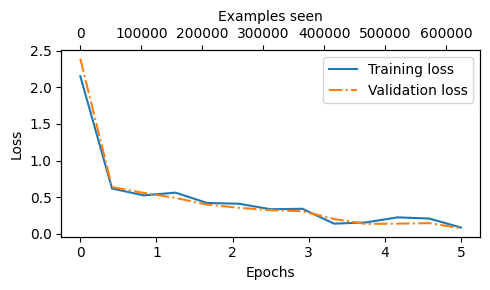

In [50]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_loss))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_loss))

plot_values(epochs_tensor, examples_seen_tensor, train_loss, val_loss)

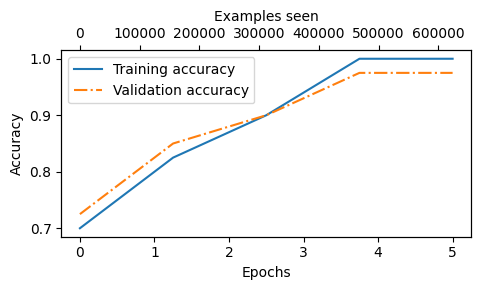

In [51]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [52]:

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


# using a LLM as a spam classifier

In [53]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [54]:
def classify_text(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(supported_context_length, max_length)]

    # handle case where there is shorter text
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_ids)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item ()
    return "spam" if predicted_label == 1 else "not spam"

In [55]:
text1 = (
    "you are a winner you have been specially"
    " selected to recieve $1000 or a $2000 prize."
)

print(classify_text(text1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [56]:
text2 = (
    "Hey, Just wanted to check if we're on"
    "for dinner? Let me know if you have"
    "time. Thanks!"
)
print(classify_text(text2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [57]:
torch.save(model.state_dict(), "spam-classifier.pth")

In [58]:
# to load

model_state_dict = torch.load("spam-classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>